# Pop dyn tests

In [1]:
%pip install -e ..

Obtaining file:///home/rstudio/boettiger-lab/rl4fisheries
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached typing-3.7.4.3-py3-none-any.whl
  Building editable for rl4fisheries (pyproject.toml) ... done
  Created wheel for rl4fisheries: filename=rl4fisheries-1.0.0-0.editable-py3-none-any.whl size=2322 sha256=2f9f00a1bb6053567050d7fa7953167bf454e0d7177265e63ad9c43f43b15507
  Stored in directory: /tmp/pip-ephem-wheel-cache-gn1d9bpy/wheels/55/1e/4a/9e3b1ec27a9439b41651c9753798340778b03ddfad8f7fc0af
Successfully built rl4fisheries
Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import pandas as pd
from typing import List, Text, Optional

from rl4fisheries import Msy, ConstEsc, CautionaryRule, AsmEnv
from rl4fisheries.envs.asm_fns import get_r_devs

In [24]:
config = {'s':0.86, 'reproducibility_mode': True}
env = AsmEnv(config=config)
_ = env.reset()

In [25]:
def simulate_ep(env, agent, other_vars: Optional[List[Text]] = []):   
    simulation = {
        't': [],
        'surv_b_obs': [],
        'bare_surv_b_obs': [], 
        'mean_wt_obs': [],
        'act': [],
        'rew': [],
        'total_pop': [],
        'newborns': [],
        'children': [],
        'adults': [],
        'non_random_newb': [],
        **{var_name: [] for var_name in other_vars}
    }
    obs, _ = env.reset()
    for t in range(env.Tmax):
        act, _ = agent.predict(obs)
        new_obs, rew, term, trunc, info = env.step(act)
        #
        simulation['t'].append(t)
        simulation['surv_b_obs'].append(
            env.bound * (obs[0]+1)/2
        )
        simulation['bare_surv_b_obs'].append(
            obs[0]
        )
        simulation['mean_wt_obs'].append(
            (
                env.parameters["min_wt"]
                + (env.parameters["max_wt"] - env.parameters["min_wt"])
                * (obs[1]+1)/2
            )
        )
        simulation['act'].append(act[0])
        simulation['rew'].append(rew)
        simulation['total_pop'].append(np.sum(env.state))
        simulation['newborns'].append(env.state[0])
        simulation['children'].append(sum(env.state[:4]))
        simulation['adults'].append(sum(env.state[4:]))
        simulation['non_random_newb'].append(
            env.parameters["bha"] * env.ssb / (1 + env.parameters["bhb"] * env.ssb)
        )
        for var_name in other_vars:
            simulation[var_name].append(getattr(env, var_name))
        #
        obs = new_obs
    #
    return simulation

In [26]:
def expand_state(age_cls):
    def wrapped(row):
        return row.state[age_cls]
    return wrapped

def add_state_columns(df, env):
    df_inner = df.copy()
    for age_cls in range(len(env.state)):
        df_inner[f'age_{age_cls:02d}_b'] = df_inner.apply(expand_state(age_cls), axis=1)
    return df_inner
    

## No Harvest

In [27]:
trivp = Msy(env = env, mortality=0)
trivial_ep = pd.DataFrame(simulate_ep(env, trivp, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))

In [6]:
# trivial_ep.head()

<Axes: title={'center': 'populations'}, xlabel='t'>

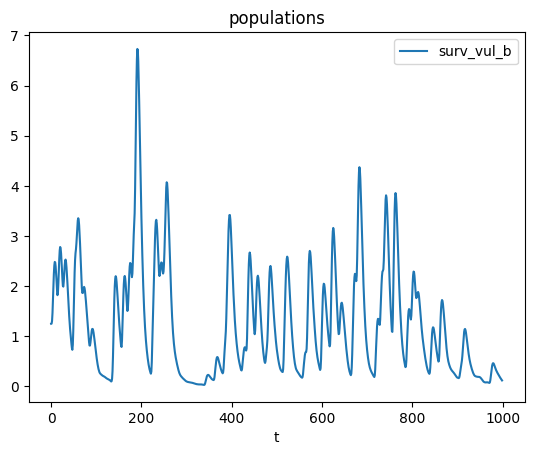

In [28]:
trivial_ep.plot(x='t', y = ['surv_vul_b'], title='populations')

<Axes: title={'center': 'Total population over time'}, xlabel='surv_vul_b', ylabel='mean_wt_obs'>

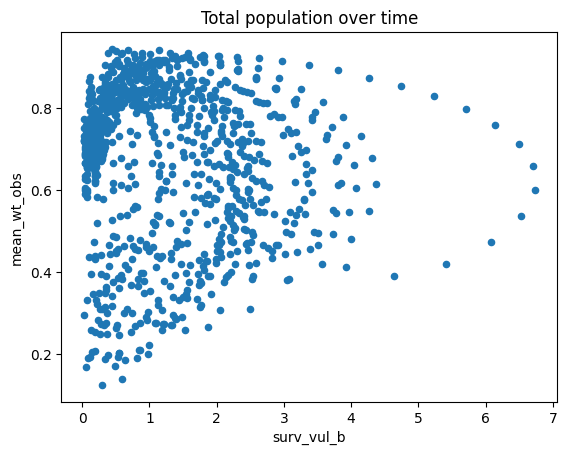

In [30]:
trivial_ep.plot(
    x='surv_vul_b', y = 'mean_wt_obs', 
    title='Total population over time', 
    kind='scatter',
)

## Optimal escapement

<Axes: title={'center': 'total pop. over time under optimal escapement'}, xlabel='t'>

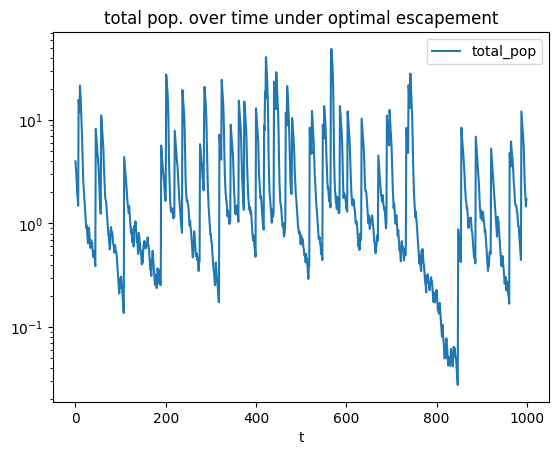

In [9]:
esc = ConstEsc(env=env, escapement = 0.010338225232077163)
esc_ep = pd.DataFrame(simulate_ep(env, esc, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))
esc_ep.plot(x='t', y = ['total_pop'], title='total pop. over time under optimal escapement', logy=True)

<Axes: title={'center': 'Total population over time'}, xlabel='surv_vul_b', ylabel='mean_wt_obs'>

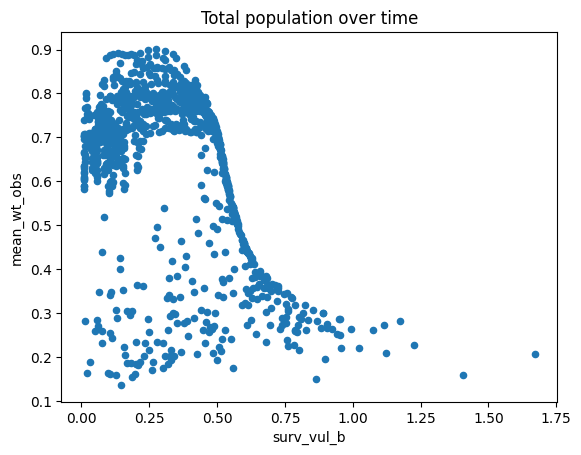

In [31]:
esc_ep.plot(
    x='surv_vul_b', y = 'mean_wt_obs', 
    title='Total population over time', 
    kind='scatter',
)

In [11]:
from stable_baselines3 import PPO

PPO_CONFIG = { 
    "observation_fn_id": 'observe_2o',
    "n_observs": 2,
}

ppo = PPO.load("../saved_agents/PPO-AsmEnv-2o.zip", env=AsmEnv(config=PPO_CONFIG), device='cpu')

<Axes: title={'center': 'total pop. over time under optimal escapement'}, xlabel='t'>

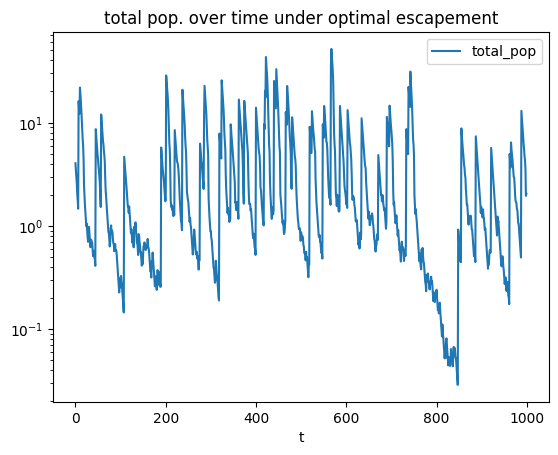

In [12]:
ppo_ep = pd.DataFrame(simulate_ep(env, ppo, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))
ppo_ep.plot(x='t', y = ['total_pop'], title='total pop. over time under optimal escapement', logy=True)

<Axes: title={'center': 'harvest over time under RL policy'}, xlabel='t'>

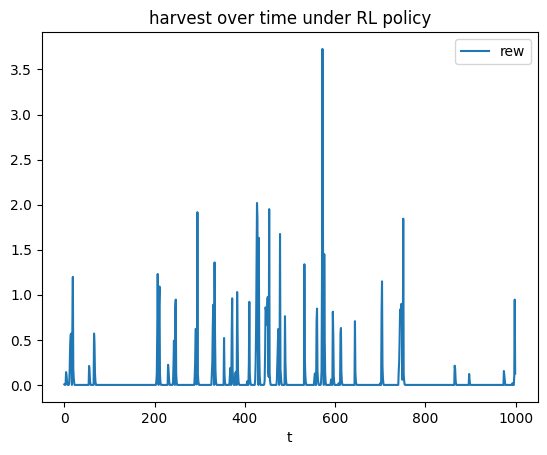

In [33]:
ppo_ep.plot(x='t', y = ['rew'], title='harvest over time under RL policy')

<Axes: title={'center': 'Total population over time'}, xlabel='surv_vul_b', ylabel='mean_wt_obs'>

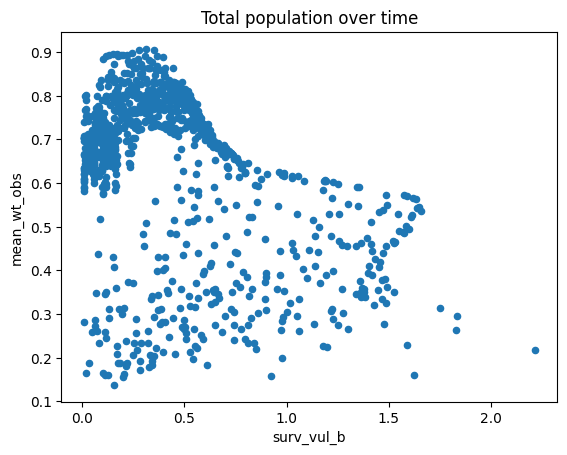

In [34]:
ppo_ep.plot(
    x='surv_vul_b', y = 'mean_wt_obs', 
    title='Total population over time', 
    kind='scatter',
)

In [35]:
cr_args = {
    'x1': 50 * 0.009159055923137423,
    'x2': 50 * 0.015139834077385755,
    'y2': 0.29119675741251316,
}
cr = CautionaryRule(env=env, **cr_args)
cr_ep = pd.DataFrame(simulate_ep(env, cr, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))
# cr_ep.plot(x='t', y = ['act'], title='total pop. over time under CR')

-0.982, -0.970, -0.418


<Axes: title={'center': 'Total population over time'}, xlabel='surv_vul_b', ylabel='mean_wt_obs'>

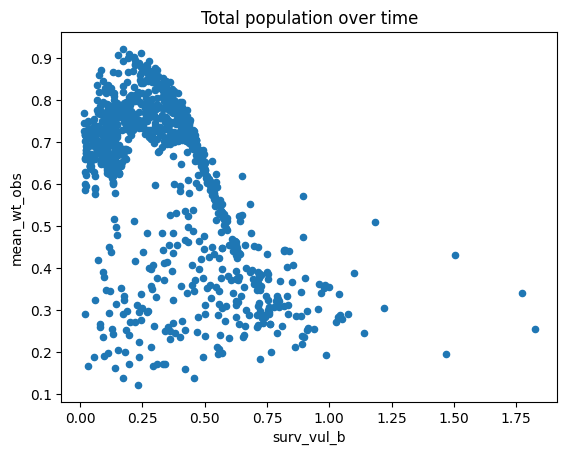

In [37]:
cr_ep.plot(
    x='surv_vul_b', y = 'mean_wt_obs', 
    title='Total population over time', 
    kind='scatter',
)

## Focusing on biomass-mean wt scatter plots

In [42]:
from tqdm import tqdm
N = 100

trivial_eps = pd.concat([
    pd.DataFrame(simulate_ep(env, trivp, other_vars=['surv_vul_b']))
    for _ in tqdm(range(N))
])

esc_eps = pd.concat([
    pd.DataFrame(simulate_ep(env, esc, other_vars=['surv_vul_b']))
    for _ in tqdm(range(N))
])

ppo_eps = pd.concat([
    pd.DataFrame(simulate_ep(env, ppo, other_vars=['surv_vul_b']))
    for _ in tqdm(range(N))
])

cr_eps = pd.concat([
    pd.DataFrame(simulate_ep(env, cr, other_vars=['surv_vul_b']))
    for _ in tqdm(range(N))
])

100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


(<Axes: title={'center': 'Unfished surv vul vs mean wt'}, xlabel='surv_vul_b', ylabel='mean_wt_obs'>,
 <Axes: title={'center': 'Esc surv vul vs mean wt'}, xlabel='surv_vul_b', ylabel='mean_wt_obs'>,
 <Axes: title={'center': 'CR surv vul vs mean wt'}, xlabel='surv_vul_b', ylabel='mean_wt_obs'>,
 <Axes: title={'center': 'RL surv vul vs mean wt'}, xlabel='surv_vul_b', ylabel='mean_wt_obs'>)

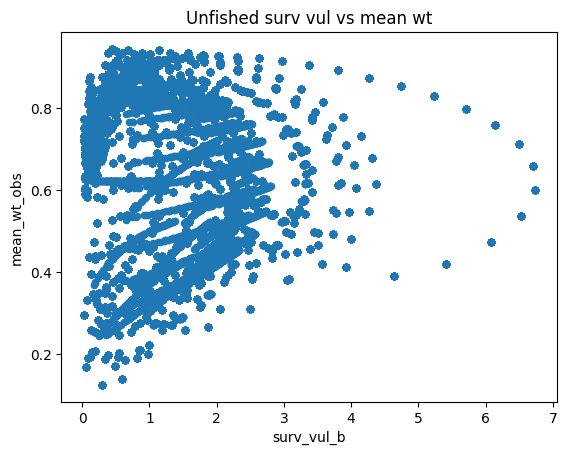

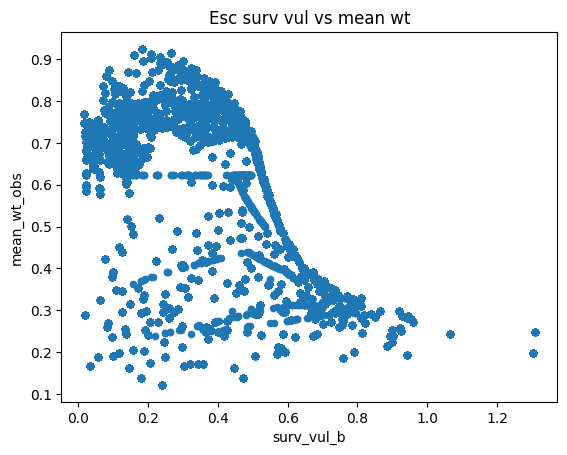

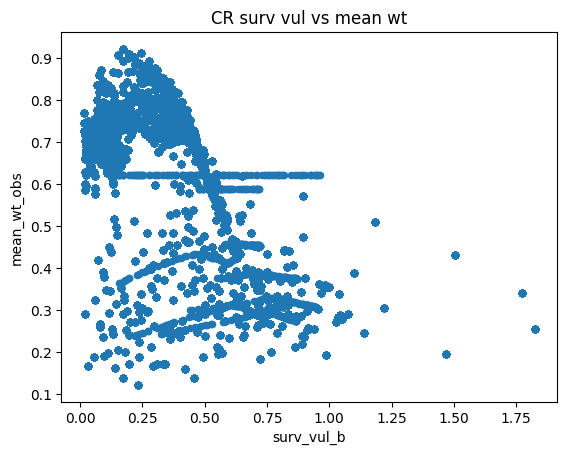

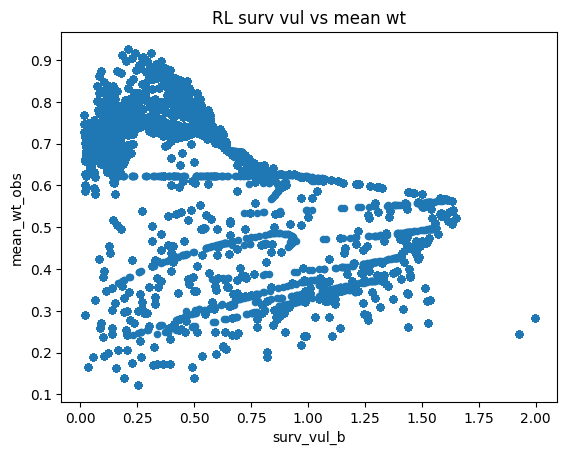

In [45]:
(
    trivial_eps.plot(
        x='surv_vul_b', y = 'mean_wt_obs', 
        title='Unfished surv vul vs mean wt', 
        kind='scatter',
    ),
    esc_eps.plot(
        x='surv_vul_b', y = 'mean_wt_obs', 
        title='Esc surv vul vs mean wt', 
        kind='scatter',
    ),
    cr_eps.plot(
        x='surv_vul_b', y = 'mean_wt_obs', 
        title='CR surv vul vs mean wt', 
        kind='scatter',
    ),
    ppo_eps.plot(
        x='surv_vul_b', y = 'mean_wt_obs', 
        title='RL surv vul vs mean wt', 
        kind='scatter',
    ),
)

In [56]:
# %pip install altair
# %pip install vega_datasets

In [54]:
def prepare_for_altair(df):
    # df = add_state_columns(df, env)
    # melted_df = df[['t', *[f'age_{i:02d}_b' for i in range(20)]]].melt(id_vars='t')
    # melted_df['population'] = melted_df['variable']
    # melted_df['biomass'] = melted_df['value']
    # return melted_df[['t', 'population', 'biomass']]
    melted_df = df[['t', 'children', 'adults']].melt(id_vars='t')
    melted_df['population'] = melted_df['variable']
    melted_df['biomass'] = melted_df['value']
    return melted_df[['t', 'population', 'biomass']]
    

In [57]:
import altair as alt

triv_population = prepare_for_altair(trivial_ep)

triv_population_short = triv_population[triv_population.t < 100]
# triv_population_short.head()
alt.Chart(triv_population_short).mark_area().encode(
    x="t:T",
    y="biomass:Q",
    color="population:N"
)

alt.Chart(...)

## Escapement

In [58]:
escp = ConstEsc(env, escapement = 0.01)
esc_ep = pd.DataFrame(simulate_ep(env, escp, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))

<Axes: title={'center': 'populations'}, xlabel='t'>

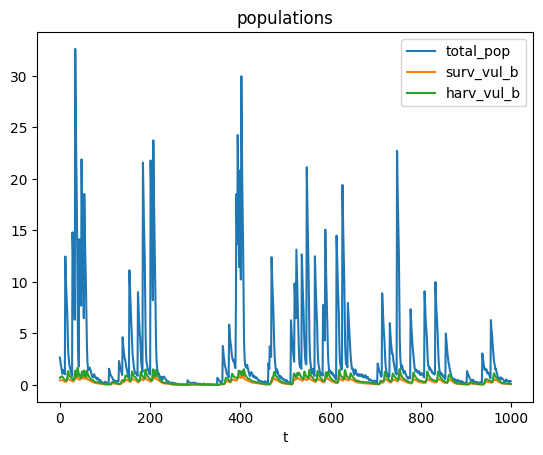

In [59]:
# esc_ep.plot(x='t', y = ['total_pop'], title='total population')
# esc_ep.plot(x='t', y = ['non_random_newb'], title='non-random newborns')
# esc_ep.plot(x='t', y = ['ssb'], title='Fished ssb')
# esc_ep.plot(x='t', y = ['newborns'], title='newborns', logy=True)
# esc_ep.plot(x='t', y = ['act'], title='actions')
# esc_ep.plot(x='t', y = ['surv_b_obs'], title='surv_b_obs')
esc_ep.plot(x='t', y = ['total_pop', 'surv_vul_b', 'harv_vul_b'], title='populations')

In [60]:
esc_population = prepare_for_altair(esc_ep)

esc_population_short = esc_population[triv_population.t < 100]

alt.Chart(esc_population_short).mark_area().encode(
    x="t:T",
    y="biomass:Q",
    color="population:N"
)

alt.Chart(...)

## MSY

In [61]:
msyp = Msy(env = env, mortality=0.057)
msy_ep = pd.DataFrame(simulate_ep(env, msyp, other_vars=['ssb', 'surv_vul_b', 'harv_vul_b', 'state']))

<Axes: title={'center': 'populations'}, xlabel='t'>

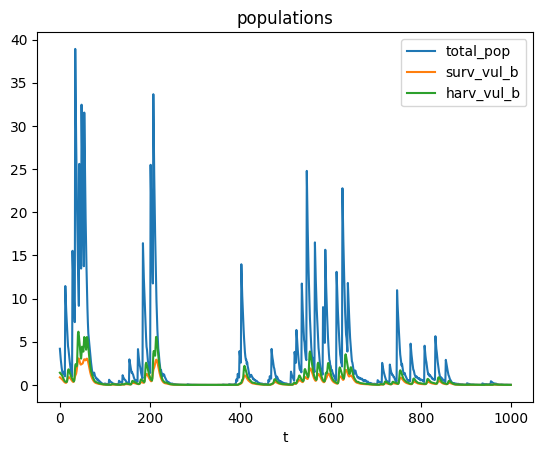

In [62]:
msy_ep.plot(x='t', y = ['total_pop', 'surv_vul_b', 'harv_vul_b'], title='populations')

In [63]:
msy_population = prepare_for_altair(msy_ep)

msy_population_short = msy_population[msy_population.t < 100]

alt.Chart(msy_population_short).mark_area().encode(
    x="t:T",
    y="biomass:Q",
    color="population:N"
)

alt.Chart(...)

<Axes: xlabel='age'>

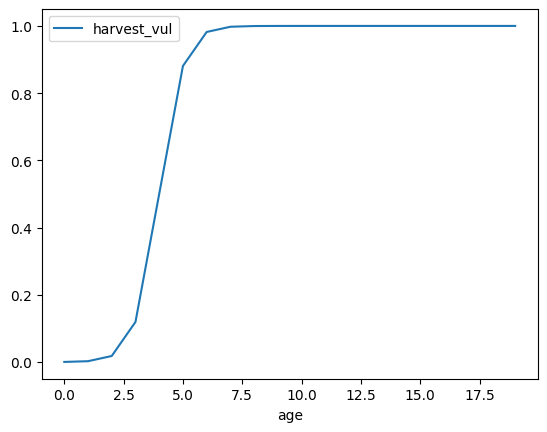

In [64]:
df = pd.DataFrame({
    'age': list(range(20)),
    'harvest_vul': env.parameters['harvest_vul']
})
df.plot(x='age')